<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Process" data-toc-modified-id="Process-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Process</a></span></li><li><span><a href="#API-Usage" data-toc-modified-id="API-Usage-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>API Usage</a></span></li><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#News-Reader-Function" data-toc-modified-id="News-Reader-Function-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>News Reader Function</a></span></li><li><span><a href="#Execute-the-News-Reader-Function" data-toc-modified-id="Execute-the-News-Reader-Function-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Execute the News Reader Function</a></span></li><li><span><a href="#Prepare-Retreived-Stories-for-Analysis" data-toc-modified-id="Prepare-Retreived-Stories-for-Analysis-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Prepare Retreived Stories for Analysis</a></span><ul class="toc-item"><li><span><a href="#Combine-Data" data-toc-modified-id="Combine-Data-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Combine Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>EDA</a></span></li></ul></li><li><span><a href="#Save-Results" data-toc-modified-id="Save-Results-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Save Results</a></span><ul class="toc-item"><li><span><a href="#Save-.csv-File" data-toc-modified-id="Save-.csv-File-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Save .csv File</a></span></li><li><span><a href="#-Database-Access-Functions" data-toc-modified-id="-Database-Access-Functions-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span> Database Access Functions</a></span></li><li><span><a href="#-Establish-Connection" data-toc-modified-id="-Establish-Connection-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span> Establish Connection</a></span></li><li><span><a href="#Initiate-creation-of-the-file" data-toc-modified-id="Initiate-creation-of-the-file-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>Initiate creation of the file</a></span></li></ul></li><li><span><a href="#Verify-the-Table-has-been-Created" data-toc-modified-id="Verify-the-Table-has-been-Created-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Verify the Table has been Created</a></span></li><li><span><a href="#-Add-a-Time-Window-to-the-DataFrame" data-toc-modified-id="-Add-a-Time-Window-to-the-DataFrame-10"><span class="toc-item-num">10&nbsp;&nbsp;</span> Add a Time Window to the DataFrame</a></span></li></ul></div>

<h2>Overview

This notebook details the steps taken to gather news stories related to the Camp Fire to be used during the Text Analysis process.

<h2>Process

The __[NewsApi](https://newsapi.org/)__ was used to pull all stories between November 8 and November 30th, using the following keywords in successive searches: 'wildfire', 'camp fire', 'percent contained', 'evacuate', 'flames', 'paradise', 'cal fire'. Through trial and error and initial inspection of the results, these keywords seem to fetch the largest proportion of results of interest. Other keyword searches were discarded because the proportion of hits on other topics was overwhelming. E.g. a search on 'fire' along resulted in many stories about the president firing cabinet members. 


<h2>API Usage


The following is an excert from the 
 __[NewsApi Client Libraries](https://newsapi.org/docs/client-libraries/python)__ 
 documentation, and illustrates how to query the NewsApi through teh python libraries. For this project we used the "Everything" query.

```

# Init
newsapi = NewsApiClient(api_key='218cae52dd41433085b710dfb9b96b0c')

# /v2/top-headlines
top_headlines = newsapi.get_top_headlines(q='bitcoin',
                                          sources='bbc-news,the-verge',
                                          category='business',
                                          language='en',
                                          country='us')

# /v2/everything
all_articles = newsapi.get_everything(q='bitcoin',
                                      sources='bbc-news,the-verge',
                                      domains='bbc.co.uk,techcrunch.com',
                                      from_param='2017-12-01',
                                      to='2017-12-12',
                                      language='en',
                                      sort_by='relevancy',
                                      page=2)

# /v2/sources
sources = newsapi.get_sources()


```

<h2>Import Libraries

In [1]:
import requests
from datetime import datetime, timedelta
import time
import pandas as pd
from pytz import timezone
import pytz
from matplotlib import pyplot as plt
from sqlalchemy import create_engine
import psycopg2
import hashlib

import warnings;
warnings.simplefilter('ignore')

%matplotlib inline

<h2>News Reader Function

This function can take a long time to run. Progress messages are printed along the way, and an elapsed time message is printed once it has completed. To ensure that we get all the relevant stories we set the threshold to a max of 100,000, and stop searching once we are done.  For all relevant queries we stop way before
the 100,000 threshold.

In [10]:
#set connection string
url = 'https://newsapi.org/v2/everything?'

#define function for reading the news
#inputs: 
#  q = query string 
#  start = start of time period for search, 
#  stop = end
def read_news(q, start, stop):
    print(f'q = {q}, start={start}, stop = {stop}')
    #set up search parameters
    param = {
        'q': q,
        'apiKey': '<valid api key goes here>',
        #    'pageSize': 100,
        'from': start,
        'to': stop,
        'language': 'en'
        }
    #initaite the request
    all_news = requests.get(url, params = param)
    #check return code. 200 means success
    if all_news.status_code != 200:
        print('Error reading news')
        return None

    print('Reading ...')
    #instantiate a timer
    start_execution = time.time()
        
    articles = all_news.json()['articles']
    
    #this loop runs a max of 100,000 times
    #this is an artifically high number specified to 
    #ensure that we get all the relevant news stories for
    #the time period. Once the more_news variable is set to 0
    #we have retreived all the articles, and break 
    #out of this function.
    for page in range(2, 100000):
        #print(page)
        param['page'] = page

        more_news = requests.get(url, params=param)
        #print(more_news)

        more_news = more_news.json()['articles']

        articles.extend(more_news)
        #print an indicator every 100 stories so the 
        #user knows something is still happening
        if (page % 100 == 0):
            print('...')
            
        #print(f'Read {len(more_news)} articles')
        if len(more_news)==0:
            #if we reach zero before the loop continues
            #we have gotten all the articles we can
            #otherwise we know there are more to get
            print('Finished - all articles retrieved')
            break
            
    #add the article to a dataframe    
    dfn = pd.DataFrame(articles) 
    #convert the source dictionary to individual columns
    dfn['source_id'] = dfn['source'].map(lambda x: x['id'])
    dfn['source_name'] = dfn['source'].map(lambda x: x['name'])
    dfn['keyword'] = q
    #print a message with the total number of articles read
    print(f'Read a total of {len(dfn)} articles')
    
    end_execution = time.time()
    print(f'Elapsed time: {end_execution - start_execution}')
    return(dfn)

<h2>Execute the News Reader Function

In [4]:
#call the news service once for each keyword in the keywords list
#this will return an array of DataFrames, one for each set of search results
def fetch_all_articles(keywords,start_date,end_date):
    df_array = []
    for i, word in enumerate(keywords):
        df_array.append( read_news(word, start_date, end_date) )
    return (df_array)

In [5]:
#parameter for the news search
key_words = ['wildfire', '"camp fire"', '"percent contained"', 'evacuate', 'flames', 'paradise', 'cal fire']
start_date = '2018-11-08'
end_date = '2018-11-30'

In [6]:
#initiate the news search 
df_list = fetch_all_articles(key_words, start_date, end_date)

q = wildfire, start=2018-11-08, stop = 2018-11-30
Reading ...
...
...
...
...
Finished - all articles retrieved
Read a total of 9712 articles
Elapsed time: 475.7478439807892
q = "camp fire", start=2018-11-08, stop = 2018-11-30
Reading ...
...
...
...
Finished - all articles retrieved
Read a total of 7183 articles
Elapsed time: 359.1877267360687
q = "percent contained", start=2018-11-08, stop = 2018-11-30
Reading ...
Finished - all articles retrieved
Read a total of 1663 articles
Elapsed time: 77.00103878974915
q = evacuate, start=2018-11-08, stop = 2018-11-30
Reading ...
...
Finished - all articles retrieved
Read a total of 3534 articles
Elapsed time: 166.57366704940796
q = flames, start=2018-11-08, stop = 2018-11-30
Reading ...
...
...
...
Finished - all articles retrieved
Read a total of 7709 articles
Elapsed time: 372.2168369293213
q = paradise, start=2018-11-08, stop = 2018-11-30
Reading ...
...
...
...
...
Finished - all articles retrieved
Read a total of 9857 articles
Elapsed tim

<h2>Prepare Retreived Stories for Analysis

During this step we put all the articles into a single dataframe. This will be cleaned and stored in a postgreSQL database for input to the text processing functions. The results of each separate search are also kept in separate dataframes for exploratory analysis in this notebook. They are not save separately.

<h3>Combine Data

In [13]:
# #concatentat all the news stories into a single dataframe
# #we keep them separate, too
# #this step may be unnecessary now that I added a keyword column to the dataframe(s)
# #and may be removed in a future version
dfnews = df_list[0]
for i in range(1,len(df_list)):
    dfnews = pd.concat([dfnews, df_list[i]])

<h3>EDA

In [8]:
dfnews.shape

(41839, 11)

As one might expect, many of the stories were 'hits' on more than one of our keyword searches, so we drop duplicates, using the subset option to avoid having to match on the article text itself. Visual inspection confirmed the stories dropped are indeed duplicates.

In [9]:
dfnews.drop_duplicates(subset=['author', 'source_id', 'title', 'publishedAt'], inplace=True)
dfnews.reset_index(inplace=True)

In [10]:
dfnews.shape

(20869, 12)

We are left with 20,869 unique stories. Let's check some of the titles to verify relevance. 

In [11]:
dfnews.title.head()

0         How to Protect Your Pets From Wildfire Smoke
1             Drone footage shows wildfire devastation
2    Trump, Touring Fire Ruins in California, Repea...
3    Burned-Out Cars, Smoke in the Air, Aerial Assa...
4         Internet rakes Trump's solution to wildfires
Name: title, dtype: object

In [12]:
#look at subset from the middle 
dfnews.iloc[400:420].title

400    PG&E stocks and bonds hammered on worry it may...
401    How Satellites Are Tracking Devastation of Cal...
402    The Latest: Official: Several hundred structur...
403    The Wall Street Journal: Trump administration ...
404    Thanksgiving weather forecasts predict record ...
405    NASA shares high-resolution satellite images o...
406    NewsWatch: Stocks close lower as Dow logs long...
407    California's PG&E reports outage in area at ti...
408    Number of missing in deadly California wildfir...
409    National Guard to help search for remains from...
410    Miley Cyrus, Liam Hemsworth ‘Devastated’ By Lo...
411    Woolsey Fire: Woman captures dramatic video dr...
412    Death toll rises to 23 in California wildfire ...
413    Donald Trump's first tweet about the Californi...
414    5 Ways You Can Help California's Wildfire Victims
415    The Latest: Interior chief, California governo...
416    California fires: Winds propel fires as death ...
417    “Devil Winds” Fuel Deadl

In [13]:
dfnews.title.tail()

20864    Marine combat veteran kills 12 in rampage at C...
20865    Four Goal Rally in the 3rd Powers Wild to 4-2 ...
20866    New York’s shrinking GOP — CUOMO’s Iowa ground...
20867    Sabres Stay Patient and Rally to Defeat the Wi...
20868    Mistakes in the First Period Doom Wild in 3-1 ...
Name: title, dtype: object

.....more visual inspection

In [ ]:
dfnews.columns

In [15]:
df_short = dfnews[['title','keyword']]

In [16]:
df_short.iloc[400:420]

,title,keyword
400,PG&E stocks and bonds hammered on worry it may...,wildfire
401,How Satellites Are Tracking Devastation of Cal...,wildfire
402,The Latest: Official: Several hundred structur...,wildfire
403,The Wall Street Journal: Trump administration ...,wildfire
404,Thanksgiving weather forecasts predict record ...,wildfire
405,NASA shares high-resolution satellite images o...,wildfire
406,NewsWatch: Stocks close lower as Dow logs long...,wildfire
407,California's PG&E reports outage in area at ti...,wildfire
408,Number of missing in deadly California wildfir...,wildfire
409,National Guard to help search for remains from...,wildfire


In [63]:
col_subset = [ 'keyword', 'title', 'content', 'description', 'publishedAt', 'author', 'url', 'source_id', 'source_name']
dfnews = dfnews[col_subset]
dfnews.head()


,keyword,title,content,description,publishedAt,author,url,source_id,source_name
0,wildfire,How to Protect Your Pets From Wildfire Smoke,Your pets breathe the same air you do. If your...,Your pets breathe the same air you do. If you’...,2018-11-15T16:30:00Z,"Beth Skwarecki on Vitals, shared by Beth Skwar...",https://vitals.lifehacker.com/how-to-protect-y...,None,Lifehacker.com
1,wildfire,Drone footage shows wildfire devastation,Chat with us in Facebook Messenger. Find out w...,CNN captured this drone footage that shows the...,2018-11-19T19:27:40Z,None,https://www.cnn.com/videos/us/2018/11/19/calif...,cnn,CNN
2,wildfire,"Trump, Touring Fire Ruins in California, Repea...","Calling forest management a very big problem, ...","In the incinerated remains of Paradise, the pr...",2018-11-18T00:34:36Z,THOMAS FULLER,https://www.nytimes.com/2018/11/17/us/trump-ca...,the-new-york-times,The New York Times
3,wildfire,"Burned-Out Cars, Smoke in the Air, Aerial Assa...",When you are driving through these streets and...,"Streets in Paradise, Calif., were cluttered wi...",2018-11-13T10:00:11Z,TIM ARANGO,https://www.nytimes.com/2018/11/13/us/californ...,the-new-york-times,The New York Times
4,wildfire,Internet rakes Trump's solution to wildfires,Chat with us in Facebook Messenger. Find out w...,President Donald Trump offered a Finnish solut...,2018-11-20T01:29:44Z,None,https://www.cnn.com/videos/politics/2018/11/20...,cnn,CNN


<h2>Save Results

<h3>Save .csv File

Keep a copy in a local csv file. We add a time stamp to the file name to prevent overwriting the file. This was helpful during initial trial and error as we worked to determine the parameters to use for our final pull.

In [66]:
#save a local copy file
now = time.time()
dfnews.to_csv(f'../tempdata/news_all_{now:.0f}.csv')

Write the file to a new table in the database. This will be the source data for the text processing phase.

<h3> Database Access Functions

In [11]:
# Write the posts data to a SQL table
def write_to_database(df, engine = None, table = None, chunksize = 1000, exist_action='replace'):
    # write posts to the posts table
    if engine == None:
        return
    else:
        df.to_sql(table, con=engine, index=False, if_exists=exist_action)

        
# Read in data from SQL database
def read_from_database(SQL, engine = None):
    # write posts to the posts table
    if engine == None:
        return
    return pd.read_sql(SQL, con = engine)

    

<h3> Establish Connection

In [10]:
# get the connection string
conn_str = 'postgres://postgres:<valid DNS goes here>'

# Database engine
engine = create_engine(conn_str)

<h3>Initiate creation of the file

This is a large file, but the API handles writing it in 'chunks' set with the 'chunksize=' parameter. In the write function above the default value is set to a chunksize of 1000.

In [102]:
#instantiate a timer
news_table_name = 'news_camp_fire'
start_execution = time.time()
print(f'Writing {dfnews.shape[0]} rows to {news_table_name}')
print(f'Started at {datetime.datetime.now().hour}:{datetime.datetime.now().minute:}:{datetime.datetime.now().second}')


#write the data to a new table, overwrite if exist
write_to_database(dfnews, engine = engine, table = news_table_name, exist_action='replace')

end_execution = time.time()
print(f'Elapsed time: {end_execution - start_execution}')


Writing 20869 rows to news_camp_fire
Started at 10:28:59
Elapsed time: 539.3360891342163


<h2>Verify the Table has been Created

In [14]:
#Test that it worked
SQL = f'SELECT * FROM {news_table_name}'
df2 = read_from_database(SQL, engine = engine)

In [15]:
df2.head()

,keyword,title,content,description,publishedAt,author,url,source_id,source_name,PublishedAt_dateobject,time_window
0,wildfire,How to Protect Your Pets From Wildfire Smoke,Your pets breathe the same air you do. If your...,Your pets breathe the same air you do. If you’...,2018-11-15T16:30:00Z,"Beth Skwarecki on Vitals, shared by Beth Skwar...",https://vitals.lifehacker.com/how-to-protect-y...,None,Lifehacker.com,2018-11-15 16:30:00,2018-11-15 19:00:00
1,wildfire,Drone footage shows wildfire devastation,Chat with us in Facebook Messenger. Find out w...,CNN captured this drone footage that shows the...,2018-11-19T19:27:40Z,None,https://www.cnn.com/videos/us/2018/11/19/calif...,cnn,CNN,2018-11-19 19:27:40,2018-11-19 19:00:00
2,wildfire,"Trump, Touring Fire Ruins in California, Repea...","Calling forest management a very big problem, ...","In the incinerated remains of Paradise, the pr...",2018-11-18T00:34:36Z,THOMAS FULLER,https://www.nytimes.com/2018/11/17/us/trump-ca...,the-new-york-times,The New York Times,2018-11-18 00:34:36,2018-11-17 19:00:00
3,wildfire,"Burned-Out Cars, Smoke in the Air, Aerial Assa...",When you are driving through these streets and...,"Streets in Paradise, Calif., were cluttered wi...",2018-11-13T10:00:11Z,TIM ARANGO,https://www.nytimes.com/2018/11/13/us/californ...,the-new-york-times,The New York Times,2018-11-13 10:00:11,2018-11-13 07:00:00
4,wildfire,Internet rakes Trump's solution to wildfires,Chat with us in Facebook Messenger. Find out w...,President Donald Trump offered a Finnish solut...,2018-11-20T01:29:44Z,None,https://www.cnn.com/videos/politics/2018/11/20...,cnn,CNN,2018-11-20 01:29:44,2018-11-19 19:00:00


In [16]:
df2.shape

(20869, 11)

<h2> Add a Time Window to the DataFrame

During the analysis we decided to look at the progression of the fire in 12 hour increments. This time interval corresponds to available data on the progression of the fire. This notebook was amended to show the code that added the time_window column.

In [17]:
# Code to convert times
# https://stackoverflow.com/questions/10997577/python-timezone-conversion/18646797#18646797
def convert_datetime_timezone(dt, tz1, tz2):
    # Get timezone objects
    tz1 = pytz.timezone(tz1)
    tz2 = pytz.timezone(tz2)

    # Localize the datetime object
    dt = tz1.localize(dt)
    dt = dt.astimezone(tz2)
   # Convert the output format by creating string then reformatting
    dt = dt.strftime("%Y-%m-%d %H:%M:%S")
    dt = datetime.strptime(dt, "%Y-%m-%d %H:%M:%S")
    
    return dt

# assign a time window based on the time stamp of the tweet
def assign_time_window(dt):
    # convert UTC to california time
    dt = convert_datetime_timezone(dt,'UTC', 'US/Pacific')
    
    # strip out the date
    date = dt.strftime('%Y-%m-%d')
    cut_1 = datetime.strptime(date + " 07:00:00", "%Y-%m-%d %H:%M:%S")
    cut_2 = datetime.strptime(date + " 19:00:00", "%Y-%m-%d %H:%M:%S")
    print(dt, cut_1)
    # Check which window this falls into and return proper window
    if dt < cut_1:
        return cut_1.strftime("%Y-%m-%d %H:%M:%S")
    elif dt >= cut_1 and dt < cut_2:
        return cut_2.strftime("%Y-%m-%d %H:%M:%S")
    else:
        dt_1 = dt + timedelta(days=1)
        date_1 = dt_1.strftime('%Y-%m-%d')
        cut_3 = datetime.strptime(date_1 + " 07:00:00", "%Y-%m-%d %H:%M:%S")
        return cut_3.strftime("%Y-%m-%d %H:%M:%S")

In [18]:
df2['PublishedAt_dateobject'] = df2['publishedAt'].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))

In [19]:
df2['time_window'] = df2['PublishedAt_dateobject'].apply(lambda x: assign_time_window(x))

2018-11-15 08:30:00 2018-11-15 07:00:00
2018-11-19 11:27:40 2018-11-19 07:00:00
2018-11-17 16:34:36 2018-11-17 07:00:00
2018-11-13 02:00:11 2018-11-13 07:00:00
2018-11-19 17:29:44 2018-11-19 07:00:00
2018-11-12 08:41:29 2018-11-12 07:00:00
2018-11-20 15:19:48 2018-11-20 07:00:00
2018-11-12 15:05:54 2018-11-12 07:00:00
2018-11-21 14:52:12 2018-11-21 07:00:00
2018-11-17 07:00:57 2018-11-17 07:00:00
2018-11-25 11:52:00 2018-11-25 07:00:00
2018-11-08 12:45:00 2018-11-08 07:00:00
2018-11-12 13:44:05 2018-11-12 07:00:00
2018-11-09 09:14:13 2018-11-09 07:00:00
2018-11-13 09:54:50 2018-11-13 07:00:00
2018-11-21 17:59:00 2018-11-21 07:00:00
2018-11-18 17:56:38 2018-11-18 07:00:00
2018-11-13 05:31:56 2018-11-13 07:00:00
2018-11-13 13:08:35 2018-11-13 07:00:00
2018-11-27 16:33:40 2018-11-27 07:00:00
2018-11-14 06:30:00 2018-11-14 07:00:00
2018-11-12 07:45:00 2018-11-12 07:00:00
2018-11-12 18:35:00 2018-11-12 07:00:00
2018-11-14 15:13:22 2018-11-14 07:00:00
2018-11-10 04:20:00 2018-11-10 07:00:00


2018-11-09 23:28:01 2018-11-09 07:00:00
2018-11-12 17:38:52 2018-11-12 07:00:00
2018-11-16 14:09:00 2018-11-16 07:00:00
2018-11-09 13:20:00 2018-11-09 07:00:00
2018-11-15 04:18:01 2018-11-15 07:00:00
2018-11-16 10:30:15 2018-11-16 07:00:00
2018-11-10 18:57:45 2018-11-10 07:00:00
2018-11-11 12:30:22 2018-11-11 07:00:00
2018-11-21 08:19:38 2018-11-21 07:00:00
2018-11-10 21:40:48 2018-11-10 07:00:00
2018-11-16 07:30:13 2018-11-16 07:00:00
2018-11-10 17:09:03 2018-11-10 07:00:00
2018-11-14 21:37:11 2018-11-14 07:00:00
2018-11-21 19:19:45 2018-11-21 07:00:00
2018-11-15 19:33:55 2018-11-15 07:00:00
2018-11-21 03:00:00 2018-11-21 07:00:00
2018-11-16 07:30:00 2018-11-16 07:00:00
2018-11-11 13:41:01 2018-11-11 07:00:00
2018-11-19 05:12:45 2018-11-19 07:00:00
2018-11-09 13:20:00 2018-11-09 07:00:00
2018-11-13 17:00:00 2018-11-13 07:00:00
2018-11-13 15:16:00 2018-11-13 07:00:00
2018-11-12 10:05:03 2018-11-12 07:00:00
2018-11-14 12:13:20 2018-11-14 07:00:00
2018-11-15 13:31:37 2018-11-15 07:00:00


2018-11-21 08:10:00 2018-11-21 07:00:00
2018-11-29 04:54:44 2018-11-29 07:00:00
2018-11-15 08:10:53 2018-11-15 07:00:00
2018-11-20 08:18:27 2018-11-20 07:00:00
2018-11-23 08:57:01 2018-11-23 07:00:00
2018-11-16 19:32:43 2018-11-16 07:00:00
2018-11-23 02:08:14 2018-11-23 07:00:00
2018-11-13 13:49:15 2018-11-13 07:00:00
2018-11-10 17:31:23 2018-11-10 07:00:00
2018-11-15 13:22:30 2018-11-15 07:00:00
2018-11-17 18:38:58 2018-11-17 07:00:00
2018-11-15 11:18:45 2018-11-15 07:00:00
2018-11-16 10:25:42 2018-11-16 07:00:00
2018-11-16 10:25:12 2018-11-16 07:00:00
2018-11-23 14:37:08 2018-11-23 07:00:00
2018-11-16 10:14:00 2018-11-16 07:00:00
2018-11-09 11:24:00 2018-11-09 07:00:00
2018-11-17 12:57:33 2018-11-17 07:00:00
2018-11-11 13:31:40 2018-11-11 07:00:00
2018-11-10 20:47:27 2018-11-10 07:00:00
2018-11-10 23:41:49 2018-11-10 07:00:00
2018-11-11 20:45:31 2018-11-11 07:00:00
2018-11-15 13:25:00 2018-11-15 07:00:00
2018-11-19 00:05:00 2018-11-19 07:00:00
2018-11-13 17:00:09 2018-11-13 07:00:00


2018-11-25 21:33:10 2018-11-25 07:00:00
2018-11-27 09:00:00 2018-11-27 07:00:00
2018-11-08 13:13:00 2018-11-08 07:00:00
2018-11-09 11:06:00 2018-11-09 07:00:00
2018-11-20 11:42:00 2018-11-20 07:00:00
2018-11-15 18:44:00 2018-11-15 07:00:00
2018-11-25 18:45:00 2018-11-25 07:00:00
2018-11-10 09:39:00 2018-11-10 07:00:00
2018-11-09 21:45:48 2018-11-09 07:00:00
2018-11-12 21:41:17 2018-11-12 07:00:00
2018-11-12 17:40:44 2018-11-12 07:00:00
2018-11-13 13:59:38 2018-11-13 07:00:00
2018-11-09 14:37:43 2018-11-09 07:00:00
2018-11-21 10:47:16 2018-11-21 07:00:00
2018-11-23 20:58:26 2018-11-23 07:00:00
2018-11-23 05:56:51 2018-11-23 07:00:00
2018-11-20 12:47:52 2018-11-20 07:00:00
2018-11-18 15:35:00 2018-11-18 07:00:00
2018-11-22 09:53:39 2018-11-22 07:00:00
2018-11-09 13:45:22 2018-11-09 07:00:00
2018-11-27 10:36:47 2018-11-27 07:00:00
2018-11-09 05:57:56 2018-11-09 07:00:00
2018-11-14 09:06:53 2018-11-14 07:00:00
2018-11-21 16:54:25 2018-11-21 07:00:00
2018-11-10 11:09:03 2018-11-10 07:00:00


2018-11-22 10:50:21 2018-11-22 07:00:00
2018-11-12 19:56:08 2018-11-12 07:00:00
2018-11-16 19:22:19 2018-11-16 07:00:00
2018-11-13 07:23:35 2018-11-13 07:00:00
2018-11-19 05:58:10 2018-11-19 07:00:00
2018-11-29 16:16:46 2018-11-29 07:00:00
2018-11-18 07:00:19 2018-11-18 07:00:00
2018-11-28 09:42:51 2018-11-28 07:00:00
2018-11-18 06:00:02 2018-11-18 07:00:00
2018-11-13 08:02:38 2018-11-13 07:00:00
2018-11-22 01:41:09 2018-11-22 07:00:00
2018-11-11 07:02:00 2018-11-11 07:00:00
2018-11-27 16:00:00 2018-11-27 07:00:00
2018-11-14 13:28:11 2018-11-14 07:00:00
2018-11-19 11:38:27 2018-11-19 07:00:00
2018-11-14 15:48:07 2018-11-14 07:00:00
2018-11-24 06:16:25 2018-11-24 07:00:00
2018-11-26 01:27:06 2018-11-26 07:00:00
2018-11-18 15:25:31 2018-11-18 07:00:00
2018-11-22 17:28:40 2018-11-22 07:00:00
2018-11-09 05:14:00 2018-11-09 07:00:00
2018-11-10 11:35:54 2018-11-10 07:00:00
2018-11-28 06:45:06 2018-11-28 07:00:00
2018-11-18 09:57:08 2018-11-18 07:00:00
2018-11-13 04:14:31 2018-11-13 07:00:00


2018-11-17 08:17:00 2018-11-17 07:00:00
2018-11-18 13:15:00 2018-11-18 07:00:00
2018-11-15 09:32:00 2018-11-15 07:00:00
2018-11-09 21:34:10 2018-11-09 07:00:00
2018-11-14 14:29:40 2018-11-14 07:00:00
2018-11-09 16:13:46 2018-11-09 07:00:00
2018-11-14 00:29:51 2018-11-14 07:00:00
2018-11-16 14:14:37 2018-11-16 07:00:00
2018-11-17 09:08:00 2018-11-17 07:00:00
2018-11-13 04:30:00 2018-11-13 07:00:00
2018-11-10 08:45:58 2018-11-10 07:00:00
2018-11-11 18:21:25 2018-11-11 07:00:00
2018-11-15 20:28:40 2018-11-15 07:00:00
2018-11-11 22:36:59 2018-11-11 07:00:00
2018-11-13 15:00:47 2018-11-13 07:00:00
2018-11-22 02:02:05 2018-11-22 07:00:00
2018-11-12 10:46:00 2018-11-12 07:00:00
2018-11-18 04:40:51 2018-11-18 07:00:00
2018-11-23 15:05:56 2018-11-23 07:00:00
2018-11-14 06:15:00 2018-11-14 07:00:00
2018-11-08 21:35:22 2018-11-08 07:00:00
2018-11-22 16:37:38 2018-11-22 07:00:00
2018-11-13 16:06:25 2018-11-13 07:00:00
2018-11-23 16:00:00 2018-11-23 07:00:00
2018-11-14 07:30:00 2018-11-14 07:00:00


2018-11-18 15:10:00 2018-11-18 07:00:00
2018-11-19 15:17:08 2018-11-19 07:00:00
2018-11-09 13:35:41 2018-11-09 07:00:00
2018-11-13 14:08:48 2018-11-13 07:00:00
2018-11-20 11:09:06 2018-11-20 07:00:00
2018-11-13 06:57:28 2018-11-13 07:00:00
2018-11-08 23:41:47 2018-11-08 07:00:00
2018-11-17 13:29:28 2018-11-17 07:00:00
2018-11-28 05:45:07 2018-11-28 07:00:00
2018-11-15 08:45:37 2018-11-15 07:00:00
2018-11-13 09:16:02 2018-11-13 07:00:00
2018-11-13 12:34:29 2018-11-13 07:00:00
2018-11-09 10:03:47 2018-11-09 07:00:00
2018-11-18 16:00:55 2018-11-18 07:00:00
2018-11-28 16:14:14 2018-11-28 07:00:00
2018-11-16 12:25:57 2018-11-16 07:00:00
2018-11-17 21:23:28 2018-11-17 07:00:00
2018-11-12 10:14:47 2018-11-12 07:00:00
2018-11-16 08:40:25 2018-11-16 07:00:00
2018-11-16 06:37:27 2018-11-16 07:00:00
2018-11-13 12:09:58 2018-11-13 07:00:00
2018-11-20 22:13:28 2018-11-20 07:00:00
2018-11-12 19:26:49 2018-11-12 07:00:00
2018-11-11 16:31:17 2018-11-11 07:00:00
2018-11-19 05:46:58 2018-11-19 07:00:00


2018-11-28 11:08:37 2018-11-28 07:00:00
2018-11-14 14:18:19 2018-11-14 07:00:00
2018-11-18 16:02:35 2018-11-18 07:00:00
2018-11-15 07:58:39 2018-11-15 07:00:00
2018-11-26 08:15:03 2018-11-26 07:00:00
2018-11-09 13:53:31 2018-11-09 07:00:00
2018-11-13 12:00:41 2018-11-13 07:00:00
2018-11-13 05:20:19 2018-11-13 07:00:00
2018-11-14 16:54:56 2018-11-14 07:00:00
2018-11-14 18:56:59 2018-11-14 07:00:00
2018-11-13 07:24:32 2018-11-13 07:00:00
2018-11-29 23:08:33 2018-11-29 07:00:00
2018-11-23 05:00:00 2018-11-23 07:00:00
2018-11-22 04:26:43 2018-11-22 07:00:00
2018-11-16 04:01:05 2018-11-16 07:00:00
2018-11-13 23:37:13 2018-11-13 07:00:00
2018-11-15 19:37:09 2018-11-15 07:00:00
2018-11-15 19:37:09 2018-11-15 07:00:00
2018-11-18 09:57:08 2018-11-18 07:00:00
2018-11-16 10:17:07 2018-11-16 07:00:00
2018-11-19 00:37:07 2018-11-19 07:00:00
2018-11-19 00:37:07 2018-11-19 07:00:00
2018-11-22 05:37:09 2018-11-22 07:00:00
2018-11-22 05:37:09 2018-11-22 07:00:00
2018-11-12 04:00:00 2018-11-12 07:00:00


2018-11-22 17:50:49 2018-11-22 07:00:00
2018-11-26 21:33:05 2018-11-26 07:00:00
2018-11-13 09:38:52 2018-11-13 07:00:00
2018-11-16 23:33:57 2018-11-16 07:00:00
2018-11-13 03:00:05 2018-11-13 07:00:00
2018-11-17 16:28:00 2018-11-17 07:00:00
2018-11-12 22:01:44 2018-11-12 07:00:00
2018-11-09 02:00:04 2018-11-09 07:00:00
2018-11-21 11:13:13 2018-11-21 07:00:00
2018-11-09 14:17:31 2018-11-09 07:00:00
2018-11-25 10:01:15 2018-11-25 07:00:00
2018-11-13 08:21:17 2018-11-13 07:00:00
2018-11-13 07:06:30 2018-11-13 07:00:00
2018-11-09 17:56:08 2018-11-09 07:00:00
2018-11-20 17:25:54 2018-11-20 07:00:00
2018-11-18 21:56:47 2018-11-18 07:00:00
2018-11-09 06:47:28 2018-11-09 07:00:00
2018-11-11 22:05:56 2018-11-11 07:00:00
2018-11-09 09:45:19 2018-11-09 07:00:00
2018-11-17 20:22:28 2018-11-17 07:00:00
2018-11-15 12:53:28 2018-11-15 07:00:00
2018-11-12 07:06:22 2018-11-12 07:00:00
2018-11-29 05:00:00 2018-11-29 07:00:00
2018-11-08 23:03:38 2018-11-08 07:00:00
2018-11-12 02:51:00 2018-11-12 07:00:00


2018-11-12 10:55:08 2018-11-12 07:00:00
2018-11-11 15:00:10 2018-11-11 07:00:00
2018-11-23 15:41:01 2018-11-23 07:00:00
2018-11-09 14:10:08 2018-11-09 07:00:00
2018-11-19 05:50:02 2018-11-19 07:00:00
2018-11-16 08:05:04 2018-11-16 07:00:00
2018-11-15 08:09:29 2018-11-15 07:00:00
2018-11-11 13:20:08 2018-11-11 07:00:00
2018-11-15 10:00:33 2018-11-15 07:00:00
2018-11-09 13:31:35 2018-11-09 07:00:00
2018-11-20 03:44:00 2018-11-20 07:00:00
2018-11-18 06:17:12 2018-11-18 07:00:00
2018-11-11 22:39:51 2018-11-11 07:00:00
2018-11-28 03:03:14 2018-11-28 07:00:00
2018-11-12 20:39:10 2018-11-12 07:00:00
2018-11-27 14:25:06 2018-11-27 07:00:00
2018-11-27 11:05:57 2018-11-27 07:00:00
2018-11-16 02:01:38 2018-11-16 07:00:00
2018-11-21 22:41:33 2018-11-21 07:00:00
2018-11-20 13:24:38 2018-11-20 07:00:00
2018-11-10 16:35:38 2018-11-10 07:00:00
2018-11-17 10:03:00 2018-11-17 07:00:00
2018-11-26 09:11:43 2018-11-26 07:00:00
2018-11-09 09:36:00 2018-11-09 07:00:00
2018-11-18 22:00:05 2018-11-18 07:00:00


2018-11-15 01:09:53 2018-11-15 07:00:00
2018-11-15 03:44:35 2018-11-15 07:00:00
2018-11-10 08:36:13 2018-11-10 07:00:00
2018-11-18 16:51:17 2018-11-18 07:00:00
2018-11-11 18:13:03 2018-11-11 07:00:00
2018-11-13 18:26:34 2018-11-13 07:00:00
2018-11-23 20:58:26 2018-11-23 07:00:00
2018-11-27 12:26:21 2018-11-27 07:00:00
2018-11-25 08:37:28 2018-11-25 07:00:00
2018-11-16 15:27:34 2018-11-16 07:00:00
2018-11-16 22:15:06 2018-11-16 07:00:00
2018-11-09 14:44:58 2018-11-09 07:00:00
2018-11-29 22:00:24 2018-11-29 07:00:00
2018-11-16 09:55:04 2018-11-16 07:00:00
2018-11-12 08:10:49 2018-11-12 07:00:00
2018-11-14 07:43:27 2018-11-14 07:00:00
2018-11-12 21:48:14 2018-11-12 07:00:00
2018-11-11 08:53:28 2018-11-11 07:00:00
2018-11-19 02:39:52 2018-11-19 07:00:00
2018-11-28 07:31:26 2018-11-28 07:00:00
2018-11-14 10:00:09 2018-11-14 07:00:00
2018-11-14 15:39:56 2018-11-14 07:00:00
2018-11-16 08:35:56 2018-11-16 07:00:00
2018-11-16 08:08:45 2018-11-16 07:00:00
2018-11-29 13:50:02 2018-11-29 07:00:00


2018-11-27 09:34:22 2018-11-27 07:00:00
2018-11-11 21:20:48 2018-11-11 07:00:00
2018-11-12 21:48:25 2018-11-12 07:00:00
2018-11-08 12:11:35 2018-11-08 07:00:00
2018-11-17 21:11:56 2018-11-17 07:00:00
2018-11-20 12:33:58 2018-11-20 07:00:00
2018-11-27 14:10:09 2018-11-27 07:00:00
2018-11-13 04:04:18 2018-11-13 07:00:00
2018-11-20 09:47:00 2018-11-20 07:00:00
2018-11-19 14:51:35 2018-11-19 07:00:00
2018-11-27 13:15:48 2018-11-27 07:00:00
2018-11-11 12:30:22 2018-11-11 07:00:00
2018-11-09 21:48:31 2018-11-09 07:00:00
2018-11-14 21:43:33 2018-11-14 07:00:00
2018-11-20 15:35:38 2018-11-20 07:00:00
2018-11-23 19:35:09 2018-11-23 07:00:00
2018-11-10 12:34:59 2018-11-10 07:00:00
2018-11-18 07:54:06 2018-11-18 07:00:00
2018-11-09 09:03:26 2018-11-09 07:00:00
2018-11-12 22:54:17 2018-11-12 07:00:00
2018-11-14 21:46:06 2018-11-14 07:00:00
2018-11-29 06:56:06 2018-11-29 07:00:00
2018-11-28 12:32:36 2018-11-28 07:00:00
2018-11-19 20:30:34 2018-11-19 07:00:00
2018-11-09 14:45:04 2018-11-09 07:00:00


2018-11-09 14:28:47 2018-11-09 07:00:00
2018-11-10 16:44:05 2018-11-10 07:00:00
2018-11-12 03:22:29 2018-11-12 07:00:00
2018-11-13 13:53:25 2018-11-13 07:00:00
2018-11-14 03:36:39 2018-11-14 07:00:00
2018-11-14 07:40:41 2018-11-14 07:00:00
2018-11-12 01:32:22 2018-11-12 07:00:00
2018-11-14 07:13:50 2018-11-14 07:00:00
2018-11-13 09:09:06 2018-11-13 07:00:00
2018-11-11 01:38:46 2018-11-11 07:00:00
2018-11-11 08:13:46 2018-11-11 07:00:00
2018-11-12 01:59:07 2018-11-12 07:00:00
2018-11-10 23:52:01 2018-11-10 07:00:00
2018-11-10 15:00:07 2018-11-10 07:00:00
2018-11-30 10:01:16 2018-11-30 07:00:00
2018-11-14 00:05:02 2018-11-14 07:00:00
2018-11-11 14:52:38 2018-11-11 07:00:00
2018-11-18 05:38:26 2018-11-18 07:00:00
2018-11-20 02:02:17 2018-11-20 07:00:00
2018-11-19 00:37:07 2018-11-19 07:00:00
2018-11-13 15:51:05 2018-11-13 07:00:00
2018-11-13 21:08:04 2018-11-13 07:00:00
2018-11-28 12:29:26 2018-11-28 07:00:00
2018-11-16 18:30:00 2018-11-16 07:00:00
2018-11-08 13:37:37 2018-11-08 07:00:00


2018-11-20 13:40:30 2018-11-20 07:00:00
2018-11-15 13:00:00 2018-11-15 07:00:00
2018-11-09 14:25:00 2018-11-09 07:00:00
2018-11-17 05:45:00 2018-11-17 07:00:00
2018-11-10 23:18:29 2018-11-10 07:00:00
2018-11-18 08:19:52 2018-11-18 07:00:00
2018-11-14 12:10:00 2018-11-14 07:00:00
2018-11-22 18:30:00 2018-11-22 07:00:00
2018-11-19 08:02:52 2018-11-19 07:00:00
2018-11-20 01:00:37 2018-11-20 07:00:00
2018-11-22 08:00:37 2018-11-22 07:00:00
2018-11-13 14:50:24 2018-11-13 07:00:00
2018-11-18 10:30:00 2018-11-18 07:00:00
2018-11-19 01:40:26 2018-11-19 07:00:00
2018-11-26 16:56:19 2018-11-26 07:00:00
2018-11-19 07:09:53 2018-11-19 07:00:00
2018-11-12 21:45:12 2018-11-12 07:00:00
2018-11-11 08:25:29 2018-11-11 07:00:00
2018-11-11 12:07:55 2018-11-11 07:00:00
2018-11-13 08:14:48 2018-11-13 07:00:00
2018-11-21 00:07:19 2018-11-21 07:00:00
2018-11-13 17:55:52 2018-11-13 07:00:00
2018-11-13 07:14:05 2018-11-13 07:00:00
2018-11-14 05:57:15 2018-11-14 07:00:00
2018-11-14 14:19:57 2018-11-14 07:00:00


2018-11-10 16:00:00 2018-11-10 07:00:00
2018-11-08 10:41:48 2018-11-08 07:00:00
2018-11-13 23:04:42 2018-11-13 07:00:00
2018-11-27 22:53:25 2018-11-27 07:00:00
2018-11-28 13:49:15 2018-11-28 07:00:00
2018-11-22 14:37:13 2018-11-22 07:00:00
2018-11-15 03:54:05 2018-11-15 07:00:00
2018-11-19 05:51:50 2018-11-19 07:00:00
2018-11-16 13:04:16 2018-11-16 07:00:00
2018-11-15 07:40:32 2018-11-15 07:00:00
2018-11-14 22:40:52 2018-11-14 07:00:00
2018-11-28 15:31:49 2018-11-28 07:00:00
2018-11-09 10:15:00 2018-11-09 07:00:00
2018-11-10 09:05:00 2018-11-10 07:00:00
2018-11-29 20:34:06 2018-11-29 07:00:00
2018-11-20 06:55:51 2018-11-20 07:00:00
2018-11-26 10:33:01 2018-11-26 07:00:00
2018-11-09 07:24:00 2018-11-09 07:00:00
2018-11-14 10:55:44 2018-11-14 07:00:00
2018-11-26 05:14:55 2018-11-26 07:00:00
2018-11-19 18:00:00 2018-11-19 07:00:00
2018-11-27 14:42:29 2018-11-27 07:00:00
2018-11-13 04:45:00 2018-11-13 07:00:00
2018-11-17 06:22:43 2018-11-17 07:00:00
2018-11-11 14:03:27 2018-11-11 07:00:00


2018-11-16 19:18:16 2018-11-16 07:00:00
2018-11-14 11:00:00 2018-11-14 07:00:00
2018-11-13 11:45:57 2018-11-13 07:00:00
2018-11-28 09:46:57 2018-11-28 07:00:00
2018-11-14 14:51:12 2018-11-14 07:00:00
2018-11-27 14:06:35 2018-11-27 07:00:00
2018-11-16 11:32:53 2018-11-16 07:00:00
2018-11-25 11:06:00 2018-11-25 07:00:00
2018-11-23 05:18:00 2018-11-23 07:00:00
2018-11-20 19:26:25 2018-11-20 07:00:00
2018-11-25 05:41:55 2018-11-25 07:00:00
2018-11-18 06:34:18 2018-11-18 07:00:00
2018-11-10 02:00:05 2018-11-10 07:00:00
2018-11-25 10:10:00 2018-11-25 07:00:00
2018-11-19 08:27:04 2018-11-19 07:00:00
2018-11-15 05:36:42 2018-11-15 07:00:00
2018-11-13 16:13:32 2018-11-13 07:00:00
2018-11-10 18:00:16 2018-11-10 07:00:00
2018-11-27 01:54:46 2018-11-27 07:00:00
2018-11-27 12:05:00 2018-11-27 07:00:00
2018-11-13 03:51:49 2018-11-13 07:00:00
2018-11-14 05:30:00 2018-11-14 07:00:00
2018-11-14 11:40:46 2018-11-14 07:00:00
2018-11-15 21:20:36 2018-11-15 07:00:00
2018-11-16 05:00:27 2018-11-16 07:00:00


2018-11-16 14:32:04 2018-11-16 07:00:00
2018-11-09 07:13:07 2018-11-09 07:00:00
2018-11-19 11:48:27 2018-11-19 07:00:00
2018-11-11 15:49:19 2018-11-11 07:00:00
2018-11-10 16:00:00 2018-11-10 07:00:00
2018-11-09 21:56:01 2018-11-09 07:00:00
2018-11-29 05:59:21 2018-11-29 07:00:00
2018-11-15 19:23:44 2018-11-15 07:00:00
2018-11-27 03:35:19 2018-11-27 07:00:00
2018-11-29 10:17:39 2018-11-29 07:00:00
2018-11-27 08:36:13 2018-11-27 07:00:00
2018-11-22 09:10:05 2018-11-22 07:00:00
2018-11-28 08:09:03 2018-11-28 07:00:00
2018-11-16 22:08:00 2018-11-16 07:00:00
2018-11-12 13:41:00 2018-11-12 07:00:00
2018-11-17 02:26:00 2018-11-17 07:00:00
2018-11-12 13:40:30 2018-11-12 07:00:00
2018-11-25 04:00:09 2018-11-25 07:00:00
2018-11-09 12:33:04 2018-11-09 07:00:00
2018-11-12 22:46:00 2018-11-12 07:00:00
2018-11-13 22:45:22 2018-11-13 07:00:00
2018-11-14 23:32:49 2018-11-14 07:00:00
2018-11-12 15:04:00 2018-11-12 07:00:00
2018-11-12 23:02:45 2018-11-12 07:00:00
2018-11-18 11:26:36 2018-11-18 07:00:00


2018-11-17 00:01:38 2018-11-17 07:00:00
2018-11-10 18:45:29 2018-11-10 07:00:00
2018-11-21 12:50:17 2018-11-21 07:00:00
2018-11-16 05:06:30 2018-11-16 07:00:00
2018-11-25 16:31:09 2018-11-25 07:00:00
2018-11-10 07:50:02 2018-11-10 07:00:00
2018-11-10 14:11:41 2018-11-10 07:00:00
2018-11-10 14:49:59 2018-11-10 07:00:00
2018-11-13 00:07:15 2018-11-13 07:00:00
2018-11-27 07:55:59 2018-11-27 07:00:00
2018-11-22 14:15:29 2018-11-22 07:00:00
2018-11-26 10:37:10 2018-11-26 07:00:00
2018-11-19 14:23:54 2018-11-19 07:00:00
2018-11-23 14:32:56 2018-11-23 07:00:00
2018-11-24 06:48:21 2018-11-24 07:00:00
2018-11-19 00:14:01 2018-11-19 07:00:00
2018-11-18 08:02:00 2018-11-18 07:00:00
2018-11-15 04:00:38 2018-11-15 07:00:00
2018-11-10 06:19:00 2018-11-10 07:00:00
2018-11-10 07:09:06 2018-11-10 07:00:00
2018-11-12 01:20:15 2018-11-12 07:00:00
2018-11-15 14:21:50 2018-11-15 07:00:00
2018-11-16 05:18:13 2018-11-16 07:00:00
2018-11-21 13:23:53 2018-11-21 07:00:00
2018-11-24 04:26:38 2018-11-24 07:00:00


2018-11-18 12:20:37 2018-11-18 07:00:00
2018-11-10 09:00:20 2018-11-10 07:00:00
2018-11-12 16:00:42 2018-11-12 07:00:00
2018-11-18 19:12:17 2018-11-18 07:00:00
2018-11-10 19:38:56 2018-11-10 07:00:00
2018-11-13 05:30:33 2018-11-13 07:00:00
2018-11-28 14:29:46 2018-11-28 07:00:00
2018-11-26 11:00:00 2018-11-26 07:00:00
2018-11-21 10:55:33 2018-11-21 07:00:00
2018-11-14 17:00:26 2018-11-14 07:00:00
2018-11-19 00:29:42 2018-11-19 07:00:00
2018-11-09 13:28:45 2018-11-09 07:00:00
2018-11-17 22:01:00 2018-11-17 07:00:00
2018-11-19 00:57:42 2018-11-19 07:00:00
2018-11-28 21:23:16 2018-11-28 07:00:00
2018-11-12 14:36:41 2018-11-12 07:00:00
2018-11-15 14:52:41 2018-11-15 07:00:00
2018-11-21 18:20:00 2018-11-21 07:00:00
2018-11-13 17:39:20 2018-11-13 07:00:00
2018-11-09 14:39:49 2018-11-09 07:00:00
2018-11-13 18:36:49 2018-11-13 07:00:00
2018-11-14 13:49:12 2018-11-14 07:00:00
2018-11-11 12:21:32 2018-11-11 07:00:00
2018-11-23 19:32:32 2018-11-23 07:00:00
2018-11-09 15:41:10 2018-11-09 07:00:00


2018-11-28 08:35:11 2018-11-28 07:00:00
2018-11-14 19:12:28 2018-11-14 07:00:00
2018-11-21 20:07:37 2018-11-21 07:00:00
2018-11-13 18:35:39 2018-11-13 07:00:00
2018-11-10 12:00:05 2018-11-10 07:00:00
2018-11-23 12:20:44 2018-11-23 07:00:00
2018-11-13 12:32:36 2018-11-13 07:00:00
2018-11-18 17:45:05 2018-11-18 07:00:00
2018-11-12 09:05:01 2018-11-12 07:00:00
2018-11-12 08:45:00 2018-11-12 07:00:00
2018-11-17 06:00:00 2018-11-17 07:00:00
2018-11-19 12:01:15 2018-11-19 07:00:00
2018-11-16 19:29:00 2018-11-16 07:00:00
2018-11-13 07:10:47 2018-11-13 07:00:00
2018-11-11 20:50:11 2018-11-11 07:00:00
2018-11-25 12:45:01 2018-11-25 07:00:00
2018-11-22 13:31:00 2018-11-22 07:00:00
2018-11-15 11:29:35 2018-11-15 07:00:00
2018-11-30 02:17:43 2018-11-30 07:00:00
2018-11-21 08:39:32 2018-11-21 07:00:00
2018-11-23 09:37:54 2018-11-23 07:00:00
2018-11-10 04:54:06 2018-11-10 07:00:00
2018-11-13 15:09:00 2018-11-13 07:00:00
2018-11-21 13:43:00 2018-11-21 07:00:00
2018-11-18 06:57:17 2018-11-18 07:00:00


2018-11-20 16:50:54 2018-11-20 07:00:00
2018-11-20 07:30:19 2018-11-20 07:00:00
2018-11-19 12:23:02 2018-11-19 07:00:00
2018-11-19 01:00:26 2018-11-19 07:00:00
2018-11-16 09:00:00 2018-11-16 07:00:00
2018-11-14 12:16:33 2018-11-14 07:00:00
2018-11-22 09:07:40 2018-11-22 07:00:00
2018-11-18 09:15:19 2018-11-18 07:00:00
2018-11-12 22:00:56 2018-11-12 07:00:00
2018-11-12 19:35:58 2018-11-12 07:00:00
2018-11-21 17:10:01 2018-11-21 07:00:00
2018-11-25 05:24:00 2018-11-25 07:00:00
2018-11-12 17:13:37 2018-11-12 07:00:00
2018-11-18 11:31:59 2018-11-18 07:00:00
2018-11-19 14:31:47 2018-11-19 07:00:00
2018-11-09 11:24:06 2018-11-09 07:00:00
2018-11-13 17:10:15 2018-11-13 07:00:00
2018-11-13 04:11:46 2018-11-13 07:00:00
2018-11-30 04:03:29 2018-11-30 07:00:00
2018-11-13 10:12:45 2018-11-13 07:00:00
2018-11-19 15:45:58 2018-11-19 07:00:00
2018-11-09 18:21:06 2018-11-09 07:00:00
2018-11-13 14:25:17 2018-11-13 07:00:00
2018-11-16 14:14:53 2018-11-16 07:00:00
2018-11-12 02:45:00 2018-11-12 07:00:00


2018-11-25 07:54:00 2018-11-25 07:00:00
2018-11-16 16:04:43 2018-11-16 07:00:00
2018-11-17 10:37:48 2018-11-17 07:00:00
2018-11-10 12:00:00 2018-11-10 07:00:00
2018-11-22 16:25:00 2018-11-22 07:00:00
2018-11-15 03:00:00 2018-11-15 07:00:00
2018-11-20 01:27:25 2018-11-20 07:00:00
2018-11-20 09:59:51 2018-11-20 07:00:00
2018-11-09 05:53:47 2018-11-09 07:00:00
2018-11-16 19:33:29 2018-11-16 07:00:00
2018-11-16 07:36:39 2018-11-16 07:00:00
2018-11-12 11:00:18 2018-11-12 07:00:00
2018-11-13 08:05:00 2018-11-13 07:00:00
2018-11-27 09:34:52 2018-11-27 07:00:00
2018-11-11 22:09:37 2018-11-11 07:00:00
2018-11-18 18:19:54 2018-11-18 07:00:00
2018-11-16 07:37:14 2018-11-16 07:00:00
2018-11-24 00:08:56 2018-11-24 07:00:00
2018-11-25 07:50:01 2018-11-25 07:00:00
2018-11-15 15:36:13 2018-11-15 07:00:00
2018-11-16 07:40:54 2018-11-16 07:00:00
2018-11-13 20:17:30 2018-11-13 07:00:00
2018-11-16 12:25:23 2018-11-16 07:00:00
2018-11-14 11:58:00 2018-11-14 07:00:00
2018-11-14 05:11:17 2018-11-14 07:00:00


2018-11-23 04:01:09 2018-11-23 07:00:00
2018-11-17 20:41:27 2018-11-17 07:00:00
2018-11-11 13:09:20 2018-11-11 07:00:00
2018-11-27 13:15:20 2018-11-27 07:00:00
2018-11-16 14:15:00 2018-11-16 07:00:00
2018-11-21 03:57:00 2018-11-21 07:00:00
2018-11-27 08:32:20 2018-11-27 07:00:00
2018-11-08 14:27:15 2018-11-08 07:00:00
2018-11-12 04:30:00 2018-11-12 07:00:00
2018-11-17 05:28:07 2018-11-17 07:00:00
2018-11-12 04:30:00 2018-11-12 07:00:00
2018-11-21 16:30:00 2018-11-21 07:00:00
2018-11-10 01:09:21 2018-11-10 07:00:00
2018-11-09 15:25:00 2018-11-09 07:00:00
2018-11-29 02:11:03 2018-11-29 07:00:00
2018-11-16 14:27:27 2018-11-16 07:00:00
2018-11-14 16:24:19 2018-11-14 07:00:00
2018-11-12 02:00:00 2018-11-12 07:00:00
2018-11-29 16:25:37 2018-11-29 07:00:00
2018-11-23 11:30:00 2018-11-23 07:00:00
2018-11-30 05:08:43 2018-11-30 07:00:00
2018-11-11 11:33:10 2018-11-11 07:00:00
2018-11-18 21:00:37 2018-11-18 07:00:00
2018-11-28 11:45:04 2018-11-28 07:00:00
2018-11-21 05:17:55 2018-11-21 07:00:00


2018-11-12 10:48:40 2018-11-12 07:00:00
2018-11-16 06:04:48 2018-11-16 07:00:00
2018-11-23 09:00:07 2018-11-23 07:00:00
2018-11-09 12:53:00 2018-11-09 07:00:00
2018-11-14 08:33:55 2018-11-14 07:00:00
2018-11-09 01:59:05 2018-11-09 07:00:00
2018-11-13 08:24:03 2018-11-13 07:00:00
2018-11-16 19:11:13 2018-11-16 07:00:00
2018-11-09 12:26:15 2018-11-09 07:00:00
2018-11-11 11:24:21 2018-11-11 07:00:00
2018-11-08 22:28:45 2018-11-08 07:00:00
2018-11-21 05:30:15 2018-11-21 07:00:00
2018-11-12 16:00:45 2018-11-12 07:00:00
2018-11-28 09:16:09 2018-11-28 07:00:00
2018-11-16 18:20:31 2018-11-16 07:00:00
2018-11-07 21:03:19 2018-11-07 07:00:00
2018-11-14 16:37:19 2018-11-14 07:00:00
2018-11-15 21:35:33 2018-11-15 07:00:00
2018-11-19 08:26:00 2018-11-19 07:00:00
2018-11-14 08:20:02 2018-11-14 07:00:00
2018-11-14 14:23:59 2018-11-14 07:00:00
2018-11-12 10:56:23 2018-11-12 07:00:00
2018-11-13 10:02:53 2018-11-13 07:00:00
2018-11-09 06:20:56 2018-11-09 07:00:00
2018-11-15 05:30:41 2018-11-15 07:00:00


2018-11-19 19:44:58 2018-11-19 07:00:00
2018-11-25 03:00:29 2018-11-25 07:00:00
2018-11-09 07:05:28 2018-11-09 07:00:00
2018-11-17 05:20:35 2018-11-17 07:00:00
2018-11-13 15:15:17 2018-11-13 07:00:00
2018-11-21 23:34:52 2018-11-21 07:00:00
2018-11-15 23:06:00 2018-11-15 07:00:00
2018-11-22 10:39:12 2018-11-22 07:00:00
2018-11-11 20:15:07 2018-11-11 07:00:00
2018-11-16 13:35:25 2018-11-16 07:00:00
2018-11-27 03:11:52 2018-11-27 07:00:00
2018-11-12 04:15:28 2018-11-12 07:00:00
2018-11-29 05:27:52 2018-11-29 07:00:00
2018-11-22 22:29:01 2018-11-22 07:00:00
2018-11-16 22:57:48 2018-11-16 07:00:00
2018-11-12 06:34:40 2018-11-12 07:00:00
2018-11-13 07:05:24 2018-11-13 07:00:00
2018-11-21 15:40:49 2018-11-21 07:00:00
2018-11-10 08:33:25 2018-11-10 07:00:00
2018-11-08 13:19:36 2018-11-08 07:00:00
2018-11-15 04:38:51 2018-11-15 07:00:00
2018-11-08 09:43:19 2018-11-08 07:00:00
2018-11-29 09:00:53 2018-11-29 07:00:00
2018-11-14 08:21:07 2018-11-14 07:00:00
2018-11-09 14:10:39 2018-11-09 07:00:00


2018-11-30 10:47:00 2018-11-30 07:00:00
2018-11-25 12:30:52 2018-11-25 07:00:00
2018-11-11 10:14:03 2018-11-11 07:00:00
2018-11-10 11:17:58 2018-11-10 07:00:00
2018-11-14 04:28:52 2018-11-14 07:00:00
2018-11-15 06:35:59 2018-11-15 07:00:00
2018-11-29 07:05:40 2018-11-29 07:00:00
2018-11-09 06:11:28 2018-11-09 07:00:00
2018-11-10 16:50:31 2018-11-10 07:00:00
2018-11-10 02:06:10 2018-11-10 07:00:00
2018-11-28 07:21:48 2018-11-28 07:00:00
2018-11-30 12:01:40 2018-11-30 07:00:00
2018-11-27 03:00:00 2018-11-27 07:00:00
2018-11-13 07:36:00 2018-11-13 07:00:00
2018-11-21 07:15:00 2018-11-21 07:00:00
2018-11-08 15:19:53 2018-11-08 07:00:00
2018-11-29 23:21:28 2018-11-29 07:00:00
2018-11-21 16:42:56 2018-11-21 07:00:00
2018-11-28 13:36:13 2018-11-28 07:00:00
2018-11-27 05:44:21 2018-11-27 07:00:00
2018-11-09 07:00:35 2018-11-09 07:00:00
2018-11-09 20:02:28 2018-11-09 07:00:00
2018-11-19 08:31:46 2018-11-19 07:00:00
2018-11-19 02:11:42 2018-11-19 07:00:00
2018-11-09 22:12:59 2018-11-09 07:00:00


2018-11-12 08:56:43 2018-11-12 07:00:00
2018-11-20 16:10:00 2018-11-20 07:00:00
2018-11-13 12:33:59 2018-11-13 07:00:00
2018-11-21 05:10:17 2018-11-21 07:00:00
2018-11-24 21:00:00 2018-11-24 07:00:00
2018-11-23 11:17:50 2018-11-23 07:00:00
2018-11-19 22:48:14 2018-11-19 07:00:00
2018-11-10 06:45:00 2018-11-10 07:00:00
2018-11-29 08:57:22 2018-11-29 07:00:00
2018-11-29 07:21:18 2018-11-29 07:00:00
2018-11-13 15:40:21 2018-11-13 07:00:00
2018-11-20 13:41:40 2018-11-20 07:00:00
2018-11-15 09:13:00 2018-11-15 07:00:00
2018-11-11 18:24:16 2018-11-11 07:00:00
2018-11-17 03:14:37 2018-11-17 07:00:00
2018-11-20 06:34:23 2018-11-20 07:00:00
2018-11-08 13:51:04 2018-11-08 07:00:00
2018-11-14 05:30:06 2018-11-14 07:00:00
2018-11-09 14:34:00 2018-11-09 07:00:00
2018-11-20 07:23:25 2018-11-20 07:00:00
2018-11-20 16:11:32 2018-11-20 07:00:00
2018-11-12 02:37:34 2018-11-12 07:00:00
2018-11-29 04:40:34 2018-11-29 07:00:00
2018-11-21 05:35:06 2018-11-21 07:00:00
2018-11-24 01:11:29 2018-11-24 07:00:00


2018-11-24 19:54:37 2018-11-24 07:00:00
2018-11-17 00:40:00 2018-11-17 07:00:00
2018-11-23 19:38:00 2018-11-23 07:00:00
2018-11-19 11:06:25 2018-11-19 07:00:00
2018-11-07 18:14:19 2018-11-07 07:00:00
2018-11-21 06:34:00 2018-11-21 07:00:00
2018-11-08 23:05:08 2018-11-08 07:00:00
2018-11-21 14:49:34 2018-11-21 07:00:00
2018-11-22 10:02:34 2018-11-22 07:00:00
2018-11-23 07:57:26 2018-11-23 07:00:00
2018-11-25 16:00:00 2018-11-25 07:00:00
2018-11-28 01:50:10 2018-11-28 07:00:00
2018-11-28 08:34:20 2018-11-28 07:00:00
2018-11-15 03:49:11 2018-11-15 07:00:00
2018-11-08 22:49:00 2018-11-08 07:00:00
2018-11-07 21:00:00 2018-11-07 07:00:00
2018-11-16 19:40:38 2018-11-16 07:00:00
2018-11-21 09:02:53 2018-11-21 07:00:00
2018-11-13 06:31:38 2018-11-13 07:00:00
2018-11-26 04:11:47 2018-11-26 07:00:00
2018-11-16 16:40:16 2018-11-16 07:00:00
2018-11-15 10:36:08 2018-11-15 07:00:00
2018-11-17 19:55:13 2018-11-17 07:00:00
2018-11-28 07:58:00 2018-11-28 07:00:00
2018-11-30 14:59:10 2018-11-30 07:00:00


2018-11-12 13:37:04 2018-11-12 07:00:00
2018-11-11 08:51:38 2018-11-11 07:00:00
2018-11-10 07:25:29 2018-11-10 07:00:00
2018-11-15 16:59:57 2018-11-15 07:00:00
2018-11-20 03:00:00 2018-11-20 07:00:00
2018-11-30 15:27:11 2018-11-30 07:00:00
2018-11-20 10:37:15 2018-11-20 07:00:00
2018-11-11 13:37:28 2018-11-11 07:00:00
2018-11-28 01:32:46 2018-11-28 07:00:00
2018-11-20 23:06:33 2018-11-20 07:00:00
2018-11-14 23:00:38 2018-11-14 07:00:00
2018-11-11 11:31:56 2018-11-11 07:00:00
2018-11-29 01:54:14 2018-11-29 07:00:00
2018-11-09 04:13:52 2018-11-09 07:00:00
2018-11-09 14:15:30 2018-11-09 07:00:00
2018-11-13 07:30:08 2018-11-13 07:00:00
2018-11-21 04:00:46 2018-11-21 07:00:00
2018-11-26 07:26:00 2018-11-26 07:00:00
2018-11-23 11:08:34 2018-11-23 07:00:00
2018-11-23 08:14:48 2018-11-23 07:00:00
2018-11-11 18:38:45 2018-11-11 07:00:00
2018-11-25 01:25:07 2018-11-25 07:00:00
2018-11-27 15:57:00 2018-11-27 07:00:00
2018-11-10 16:32:01 2018-11-10 07:00:00
2018-11-17 15:56:59 2018-11-17 07:00:00


2018-11-29 22:05:11 2018-11-29 07:00:00
2018-11-19 09:57:32 2018-11-19 07:00:00
2018-11-17 10:22:00 2018-11-17 07:00:00
2018-11-12 09:47:45 2018-11-12 07:00:00
2018-11-26 10:01:29 2018-11-26 07:00:00
2018-11-22 21:27:12 2018-11-22 07:00:00
2018-11-30 12:10:27 2018-11-30 07:00:00
2018-11-17 13:38:30 2018-11-17 07:00:00
2018-11-24 14:33:27 2018-11-24 07:00:00
2018-11-14 12:06:47 2018-11-14 07:00:00
2018-11-08 05:41:50 2018-11-08 07:00:00
2018-11-12 16:00:00 2018-11-12 07:00:00
2018-11-27 16:00:00 2018-11-27 07:00:00
2018-11-15 03:28:44 2018-11-15 07:00:00
2018-11-30 06:00:19 2018-11-30 07:00:00
2018-11-24 03:00:00 2018-11-24 07:00:00
2018-11-15 07:31:41 2018-11-15 07:00:00
2018-11-08 04:29:06 2018-11-08 07:00:00
2018-11-28 21:50:28 2018-11-28 07:00:00
2018-11-09 06:05:23 2018-11-09 07:00:00
2018-11-09 19:51:24 2018-11-09 07:00:00
2018-11-26 05:17:21 2018-11-26 07:00:00
2018-11-28 08:23:37 2018-11-28 07:00:00
2018-11-29 14:59:00 2018-11-29 07:00:00
2018-11-14 03:54:39 2018-11-14 07:00:00


2018-11-21 21:04:45 2018-11-21 07:00:00
2018-11-24 15:34:08 2018-11-24 07:00:00
2018-11-08 05:49:30 2018-11-08 07:00:00
2018-11-27 10:54:13 2018-11-27 07:00:00
2018-11-18 17:11:01 2018-11-18 07:00:00
2018-11-09 10:35:22 2018-11-09 07:00:00
2018-11-23 19:56:19 2018-11-23 07:00:00
2018-11-30 10:35:17 2018-11-30 07:00:00
2018-11-29 03:00:01 2018-11-29 07:00:00
2018-11-10 02:52:07 2018-11-10 07:00:00
2018-11-09 08:45:10 2018-11-09 07:00:00
2018-11-08 20:56:00 2018-11-08 07:00:00
2018-11-11 00:00:00 2018-11-11 07:00:00
2018-11-09 21:00:00 2018-11-09 07:00:00
2018-11-08 21:00:00 2018-11-08 07:00:00
2018-11-18 14:14:14 2018-11-18 07:00:00
2018-11-21 21:49:42 2018-11-21 07:00:00
2018-11-17 12:30:20 2018-11-17 07:00:00
2018-11-23 08:00:10 2018-11-23 07:00:00
2018-11-11 00:57:57 2018-11-11 07:00:00
2018-11-19 11:17:03 2018-11-19 07:00:00
2018-11-14 23:17:00 2018-11-14 07:00:00
2018-11-26 17:51:55 2018-11-26 07:00:00
2018-11-16 14:53:01 2018-11-16 07:00:00
2018-11-08 07:25:40 2018-11-08 07:00:00


2018-11-29 15:42:05 2018-11-29 07:00:00
2018-11-12 07:15:24 2018-11-12 07:00:00
2018-11-09 09:30:18 2018-11-09 07:00:00
2018-11-12 14:08:52 2018-11-12 07:00:00
2018-11-07 16:21:17 2018-11-07 07:00:00
2018-11-27 09:03:17 2018-11-27 07:00:00
2018-11-26 05:37:58 2018-11-26 07:00:00
2018-11-11 07:00:59 2018-11-11 07:00:00
2018-11-26 06:00:43 2018-11-26 07:00:00
2018-11-13 03:00:00 2018-11-13 07:00:00
2018-11-19 02:53:28 2018-11-19 07:00:00
2018-11-17 12:08:27 2018-11-17 07:00:00
2018-11-17 06:02:16 2018-11-17 07:00:00
2018-11-19 06:02:22 2018-11-19 07:00:00
2018-11-26 04:00:09 2018-11-26 07:00:00
2018-11-27 20:05:00 2018-11-27 07:00:00
2018-11-08 06:54:56 2018-11-08 07:00:00
2018-11-09 01:45:02 2018-11-09 07:00:00
2018-11-09 01:45:02 2018-11-09 07:00:00
2018-11-23 15:53:21 2018-11-23 07:00:00
2018-11-28 10:09:31 2018-11-28 07:00:00
2018-11-19 01:00:00 2018-11-19 07:00:00
2018-11-27 07:31:18 2018-11-27 07:00:00
2018-11-15 11:59:00 2018-11-15 07:00:00
2018-11-21 23:53:00 2018-11-21 07:00:00


2018-11-29 11:07:19 2018-11-29 07:00:00
2018-11-22 22:07:08 2018-11-22 07:00:00
2018-11-26 09:32:00 2018-11-26 07:00:00
2018-11-12 15:11:49 2018-11-12 07:00:00
2018-11-10 11:27:47 2018-11-10 07:00:00
2018-11-15 17:18:11 2018-11-15 07:00:00
2018-11-29 14:05:11 2018-11-29 07:00:00
2018-11-07 22:24:32 2018-11-07 07:00:00
2018-11-14 16:55:28 2018-11-14 07:00:00
2018-11-09 23:20:01 2018-11-09 07:00:00
2018-11-11 20:27:50 2018-11-11 07:00:00
2018-11-28 22:00:18 2018-11-28 07:00:00
2018-11-23 07:05:04 2018-11-23 07:00:00
2018-11-15 11:00:00 2018-11-15 07:00:00
2018-11-09 00:55:50 2018-11-09 07:00:00
2018-11-09 15:12:39 2018-11-09 07:00:00
2018-11-09 01:37:31 2018-11-09 07:00:00
2018-11-08 07:03:49 2018-11-08 07:00:00
2018-11-19 19:11:36 2018-11-19 07:00:00
2018-11-09 21:29:34 2018-11-09 07:00:00
2018-11-10 07:09:30 2018-11-10 07:00:00
2018-11-29 21:08:24 2018-11-29 07:00:00
2018-11-24 15:27:29 2018-11-24 07:00:00
2018-11-28 17:59:22 2018-11-28 07:00:00
2018-11-16 19:45:29 2018-11-16 07:00:00


2018-11-21 23:34:03 2018-11-21 07:00:00
2018-11-09 08:00:00 2018-11-09 07:00:00
2018-11-18 11:50:53 2018-11-18 07:00:00
2018-11-15 16:54:54 2018-11-15 07:00:00
2018-11-30 09:48:53 2018-11-30 07:00:00
2018-11-22 06:47:46 2018-11-22 07:00:00
2018-11-24 22:14:30 2018-11-24 07:00:00
2018-11-27 13:21:42 2018-11-27 07:00:00
2018-11-26 20:04:56 2018-11-26 07:00:00
2018-11-20 15:30:36 2018-11-20 07:00:00
2018-11-26 16:17:09 2018-11-26 07:00:00
2018-11-19 22:24:19 2018-11-19 07:00:00
2018-11-12 19:00:00 2018-11-12 07:00:00
2018-11-14 06:25:43 2018-11-14 07:00:00
2018-11-23 13:07:10 2018-11-23 07:00:00
2018-11-12 13:13:41 2018-11-12 07:00:00
2018-11-23 14:00:00 2018-11-23 07:00:00
2018-11-09 11:29:00 2018-11-09 07:00:00
2018-11-23 08:15:47 2018-11-23 07:00:00
2018-11-13 05:08:51 2018-11-13 07:00:00
2018-11-25 08:44:30 2018-11-25 07:00:00
2018-11-14 01:57:34 2018-11-14 07:00:00
2018-11-08 21:35:30 2018-11-08 07:00:00
2018-11-12 06:50:01 2018-11-12 07:00:00
2018-11-09 02:05:06 2018-11-09 07:00:00


2018-11-22 12:34:44 2018-11-22 07:00:00
2018-11-09 14:42:00 2018-11-09 07:00:00
2018-11-17 13:25:55 2018-11-17 07:00:00
2018-11-27 07:31:19 2018-11-27 07:00:00
2018-11-23 03:00:05 2018-11-23 07:00:00
2018-11-20 17:15:00 2018-11-20 07:00:00
2018-11-16 13:26:48 2018-11-16 07:00:00
2018-11-22 18:22:52 2018-11-22 07:00:00
2018-11-16 14:23:49 2018-11-16 07:00:00
2018-11-16 21:04:15 2018-11-16 07:00:00
2018-11-13 17:34:56 2018-11-13 07:00:00
2018-11-29 02:12:30 2018-11-29 07:00:00
2018-11-08 06:55:00 2018-11-08 07:00:00
2018-11-20 09:26:23 2018-11-20 07:00:00
2018-11-27 05:52:41 2018-11-27 07:00:00
2018-11-23 18:46:56 2018-11-23 07:00:00
2018-11-15 02:16:33 2018-11-15 07:00:00
2018-11-29 01:00:44 2018-11-29 07:00:00
2018-11-10 19:23:51 2018-11-10 07:00:00
2018-11-26 11:04:50 2018-11-26 07:00:00
2018-11-21 10:45:00 2018-11-21 07:00:00
2018-11-09 12:09:03 2018-11-09 07:00:00
2018-11-08 12:00:00 2018-11-08 07:00:00
2018-11-20 12:18:41 2018-11-20 07:00:00
2018-11-12 18:10:16 2018-11-12 07:00:00


2018-11-11 11:30:05 2018-11-11 07:00:00
2018-11-14 14:15:16 2018-11-14 07:00:00
2018-11-18 11:19:20 2018-11-18 07:00:00
2018-11-26 16:11:23 2018-11-26 07:00:00
2018-11-25 13:51:47 2018-11-25 07:00:00
2018-11-09 04:37:45 2018-11-09 07:00:00
2018-11-20 17:29:00 2018-11-20 07:00:00
2018-11-12 14:15:24 2018-11-12 07:00:00
2018-11-17 19:05:02 2018-11-17 07:00:00
2018-11-09 18:10:01 2018-11-09 07:00:00
2018-11-20 09:00:05 2018-11-20 07:00:00
2018-11-13 07:45:52 2018-11-13 07:00:00
2018-11-17 23:05:00 2018-11-17 07:00:00
2018-11-11 06:00:00 2018-11-11 07:00:00
2018-11-16 18:25:11 2018-11-16 07:00:00
2018-11-30 11:01:13 2018-11-30 07:00:00
2018-11-13 10:00:02 2018-11-13 07:00:00
2018-11-30 09:36:57 2018-11-30 07:00:00
2018-11-15 19:25:08 2018-11-15 07:00:00
2018-11-14 12:15:25 2018-11-14 07:00:00
2018-11-30 11:43:25 2018-11-30 07:00:00
2018-11-18 12:08:24 2018-11-18 07:00:00
2018-11-19 16:15:15 2018-11-19 07:00:00
2018-11-27 09:38:22 2018-11-27 07:00:00
2018-11-21 02:46:09 2018-11-21 07:00:00


2018-11-08 03:29:00 2018-11-08 07:00:00
2018-11-10 18:09:46 2018-11-10 07:00:00
2018-11-27 10:39:27 2018-11-27 07:00:00
2018-11-25 12:06:03 2018-11-25 07:00:00
2018-11-12 21:27:01 2018-11-12 07:00:00
2018-11-25 23:07:30 2018-11-25 07:00:00
2018-11-21 04:55:23 2018-11-21 07:00:00
2018-11-19 05:50:51 2018-11-19 07:00:00
2018-11-08 16:00:00 2018-11-08 07:00:00
2018-11-17 14:12:47 2018-11-17 07:00:00
2018-11-19 23:19:29 2018-11-19 07:00:00
2018-11-23 11:42:49 2018-11-23 07:00:00
2018-11-13 09:37:06 2018-11-13 07:00:00
2018-11-19 17:11:05 2018-11-19 07:00:00
2018-11-13 10:34:24 2018-11-13 07:00:00
2018-11-19 14:03:00 2018-11-19 07:00:00
2018-11-19 13:32:00 2018-11-19 07:00:00
2018-11-24 14:11:42 2018-11-24 07:00:00
2018-11-15 10:17:52 2018-11-15 07:00:00
2018-11-14 13:40:11 2018-11-14 07:00:00
2018-11-26 07:11:13 2018-11-26 07:00:00
2018-11-09 08:15:00 2018-11-09 07:00:00
2018-11-29 02:08:31 2018-11-29 07:00:00
2018-11-24 08:46:31 2018-11-24 07:00:00
2018-11-19 17:00:37 2018-11-19 07:00:00


2018-11-20 13:35:46 2018-11-20 07:00:00
2018-11-14 15:39:00 2018-11-14 07:00:00
2018-11-20 16:01:00 2018-11-20 07:00:00
2018-11-15 04:20:33 2018-11-15 07:00:00
2018-11-29 04:21:01 2018-11-29 07:00:00
2018-11-25 17:12:52 2018-11-25 07:00:00
2018-11-29 07:00:00 2018-11-29 07:00:00
2018-11-28 11:10:18 2018-11-28 07:00:00
2018-11-21 11:00:09 2018-11-21 07:00:00
2018-11-08 08:24:00 2018-11-08 07:00:00
2018-11-12 11:59:19 2018-11-12 07:00:00
2018-11-14 01:29:13 2018-11-14 07:00:00
2018-11-22 16:00:00 2018-11-22 07:00:00
2018-11-15 02:58:06 2018-11-15 07:00:00
2018-11-14 11:25:00 2018-11-14 07:00:00
2018-11-21 08:34:07 2018-11-21 07:00:00
2018-11-18 07:23:39 2018-11-18 07:00:00
2018-11-20 11:45:00 2018-11-20 07:00:00
2018-11-15 02:00:00 2018-11-15 07:00:00
2018-11-27 03:07:30 2018-11-27 07:00:00
2018-11-13 04:41:59 2018-11-13 07:00:00
2018-11-19 14:14:04 2018-11-19 07:00:00
2018-11-24 21:28:45 2018-11-24 07:00:00
2018-11-29 03:27:03 2018-11-29 07:00:00
2018-11-16 13:54:00 2018-11-16 07:00:00


2018-11-28 21:08:29 2018-11-28 07:00:00
2018-11-09 13:49:14 2018-11-09 07:00:00
2018-11-12 18:25:28 2018-11-12 07:00:00
2018-11-15 22:01:16 2018-11-15 07:00:00
2018-11-16 06:20:25 2018-11-16 07:00:00
2018-11-08 00:14:41 2018-11-08 07:00:00
2018-11-19 03:37:29 2018-11-19 07:00:00
2018-11-12 23:30:03 2018-11-12 07:00:00
2018-11-12 04:02:46 2018-11-12 07:00:00
2018-11-11 10:50:16 2018-11-11 07:00:00
2018-11-09 14:36:33 2018-11-09 07:00:00
2018-11-12 17:40:26 2018-11-12 07:00:00
2018-11-14 23:36:13 2018-11-14 07:00:00
2018-11-13 16:31:44 2018-11-13 07:00:00
2018-11-13 02:07:07 2018-11-13 07:00:00
2018-11-14 11:00:00 2018-11-14 07:00:00
2018-11-08 15:00:21 2018-11-08 07:00:00
2018-11-14 05:21:21 2018-11-14 07:00:00
2018-11-28 06:25:04 2018-11-28 07:00:00
2018-11-19 00:00:00 2018-11-19 07:00:00
2018-11-13 08:00:00 2018-11-13 07:00:00
2018-11-15 09:02:08 2018-11-15 07:00:00
2018-11-23 23:37:37 2018-11-23 07:00:00
2018-11-28 02:00:00 2018-11-28 07:00:00
2018-11-14 22:30:53 2018-11-14 07:00:00


2018-11-13 12:47:00 2018-11-13 07:00:00
2018-11-23 20:02:00 2018-11-23 07:00:00
2018-11-23 03:07:00 2018-11-23 07:00:00
2018-11-14 10:56:00 2018-11-14 07:00:00
2018-11-22 17:18:00 2018-11-22 07:00:00
2018-11-21 15:38:00 2018-11-21 07:00:00
2018-11-27 07:05:53 2018-11-27 07:00:00
2018-11-25 18:17:34 2018-11-25 07:00:00
2018-11-17 11:04:15 2018-11-17 07:00:00
2018-11-22 02:36:06 2018-11-22 07:00:00
2018-11-22 02:36:06 2018-11-22 07:00:00
2018-11-20 07:30:38 2018-11-20 07:00:00
2018-11-15 06:13:45 2018-11-15 07:00:00
2018-11-17 16:57:45 2018-11-17 07:00:00
2018-11-26 20:01:00 2018-11-26 07:00:00
2018-11-25 10:14:00 2018-11-25 07:00:00
2018-11-21 10:41:14 2018-11-21 07:00:00
2018-11-25 12:05:00 2018-11-25 07:00:00
2018-11-20 13:30:49 2018-11-20 07:00:00
2018-11-15 08:07:16 2018-11-15 07:00:00
2018-11-27 05:13:02 2018-11-27 07:00:00
2018-11-17 11:06:34 2018-11-17 07:00:00
2018-11-27 03:00:00 2018-11-27 07:00:00
2018-11-26 03:35:02 2018-11-26 07:00:00
2018-11-20 01:59:05 2018-11-20 07:00:00


2018-11-16 06:02:31 2018-11-16 07:00:00
2018-11-12 19:00:00 2018-11-12 07:00:00
2018-11-14 16:29:12 2018-11-14 07:00:00
2018-11-28 07:12:43 2018-11-28 07:00:00
2018-11-21 05:48:18 2018-11-21 07:00:00
2018-11-20 09:10:43 2018-11-20 07:00:00
2018-11-23 19:15:29 2018-11-23 07:00:00
2018-11-27 06:35:00 2018-11-27 07:00:00
2018-11-08 12:00:27 2018-11-08 07:00:00
2018-11-12 12:58:53 2018-11-12 07:00:00
2018-11-20 01:56:28 2018-11-20 07:00:00
2018-11-26 04:00:01 2018-11-26 07:00:00
2018-11-09 05:13:00 2018-11-09 07:00:00
2018-11-30 05:00:00 2018-11-30 07:00:00
2018-11-16 22:00:00 2018-11-16 07:00:00
2018-11-18 09:36:13 2018-11-18 07:00:00
2018-11-15 18:40:08 2018-11-15 07:00:00
2018-11-21 22:04:50 2018-11-21 07:00:00
2018-11-21 19:19:48 2018-11-21 07:00:00
2018-11-12 10:00:00 2018-11-12 07:00:00
2018-11-29 01:59:00 2018-11-29 07:00:00
2018-11-28 08:22:36 2018-11-28 07:00:00
2018-11-25 05:00:56 2018-11-25 07:00:00
2018-11-29 03:37:00 2018-11-29 07:00:00
2018-11-15 06:30:00 2018-11-15 07:00:00


2018-11-08 14:04:28 2018-11-08 07:00:00
2018-11-14 21:00:00 2018-11-14 07:00:00
2018-11-23 16:00:18 2018-11-23 07:00:00
2018-11-23 18:37:30 2018-11-23 07:00:00
2018-11-12 15:57:26 2018-11-12 07:00:00
2018-11-22 17:50:15 2018-11-22 07:00:00
2018-11-09 02:19:12 2018-11-09 07:00:00
2018-11-30 05:02:01 2018-11-30 07:00:00
2018-11-18 04:00:21 2018-11-18 07:00:00
2018-11-20 11:49:26 2018-11-20 07:00:00
2018-11-12 14:30:00 2018-11-12 07:00:00
2018-11-08 14:04:00 2018-11-08 07:00:00
2018-11-08 14:04:00 2018-11-08 07:00:00
2018-11-09 23:27:37 2018-11-09 07:00:00
2018-11-07 16:00:00 2018-11-07 07:00:00
2018-11-17 21:00:00 2018-11-17 07:00:00
2018-11-08 20:48:35 2018-11-08 07:00:00
2018-11-08 15:05:00 2018-11-08 07:00:00
2018-11-09 02:37:38 2018-11-09 07:00:00
2018-11-26 07:00:00 2018-11-26 07:00:00
2018-11-16 05:00:00 2018-11-16 07:00:00
2018-11-12 12:00:51 2018-11-12 07:00:00
2018-11-12 11:49:04 2018-11-12 07:00:00
2018-11-09 09:33:50 2018-11-09 07:00:00
2018-11-08 13:26:00 2018-11-08 07:00:00


In [20]:
df2.head(25)

,keyword,title,content,description,publishedAt,author,url,source_id,source_name,PublishedAt_dateobject,time_window
0,wildfire,How to Protect Your Pets From Wildfire Smoke,Your pets breathe the same air you do. If your...,Your pets breathe the same air you do. If you’...,2018-11-15T16:30:00Z,"Beth Skwarecki on Vitals, shared by Beth Skwar...",https://vitals.lifehacker.com/how-to-protect-y...,None,Lifehacker.com,2018-11-15 16:30:00,2018-11-15 19:00:00
1,wildfire,Drone footage shows wildfire devastation,Chat with us in Facebook Messenger. Find out w...,CNN captured this drone footage that shows the...,2018-11-19T19:27:40Z,None,https://www.cnn.com/videos/us/2018/11/19/calif...,cnn,CNN,2018-11-19 19:27:40,2018-11-19 19:00:00
2,wildfire,"Trump, Touring Fire Ruins in California, Repea...","Calling forest management a very big problem, ...","In the incinerated remains of Paradise, the pr...",2018-11-18T00:34:36Z,THOMAS FULLER,https://www.nytimes.com/2018/11/17/us/trump-ca...,the-new-york-times,The New York Times,2018-11-18 00:34:36,2018-11-17 19:00:00
3,wildfire,"Burned-Out Cars, Smoke in the Air, Aerial Assa...",When you are driving through these streets and...,"Streets in Paradise, Calif., were cluttered wi...",2018-11-13T10:00:11Z,TIM ARANGO,https://www.nytimes.com/2018/11/13/us/californ...,the-new-york-times,The New York Times,2018-11-13 10:00:11,2018-11-13 07:00:00
4,wildfire,Internet rakes Trump's solution to wildfires,Chat with us in Facebook Messenger. Find out w...,President Donald Trump offered a Finnish solut...,2018-11-20T01:29:44Z,None,https://www.cnn.com/videos/politics/2018/11/20...,cnn,CNN,2018-11-20 01:29:44,2018-11-19 19:00:00
5,wildfire,California Fires: Blazes Spread as a Decimated...,"On Wagstaff Road, the streets were a bramble o...",Emergency workers are sifting through the ashe...,2018-11-12T16:41:29Z,"JULIE TURKEWITZ, JACK NICAS and THOMAS FULLER",https://www.nytimes.com/2018/11/12/us/californ...,the-new-york-times,The New York Times,2018-11-12 16:41:29,2018-11-12 19:00:00
6,wildfire,"Justice Department, Wildfire Victims, Markets:...",6. Michigan State Universitys former president...,Here’s what you need to know at the end of the...,2018-11-20T23:19:48Z,JEAN RUTTER and HIROKO MASUIKE,https://www.nytimes.com/2018/11/20/briefing/ju...,the-new-york-times,The New York Times,2018-11-20 23:19:48,2018-11-20 19:00:00
7,wildfire,Fact Check: Trump’s Misleading Claims About Ca...,The president did not specify which federal pa...,"On Twitter, the president claimed that the sta...",2018-11-12T23:05:54Z,KENDRA PIERRE-LOUIS,https://www.nytimes.com/2018/11/12/us/politics...,the-new-york-times,The New York Times,2018-11-12 23:05:54,2018-11-12 19:00:00
8,wildfire,Fire and Rain: California Storm Brings Relief ...,We had dry winds and low humidities and it ext...,Northern California saw its first significant ...,2018-11-21T22:52:12Z,SIMON ROMERO and THOMAS FULLER,https://www.nytimes.com/2018/11/21/us/wildfire...,the-new-york-times,The New York Times,2018-11-21 22:52:12,2018-11-21 19:00:00
9,wildfire,California wildfires: Trump to visit state's d...,Image copyright AFP Image caption Dogs are bei...,The toll from the Camp Fire in California has ...,2018-11-17T15:00:57Z,https://www.facebook.com/bbcnews,https://www.bbc.co.uk/news/world-us-canada-462...,bbc-news,BBC News,2018-11-17 15:00:57,2018-11-17 19:00:00


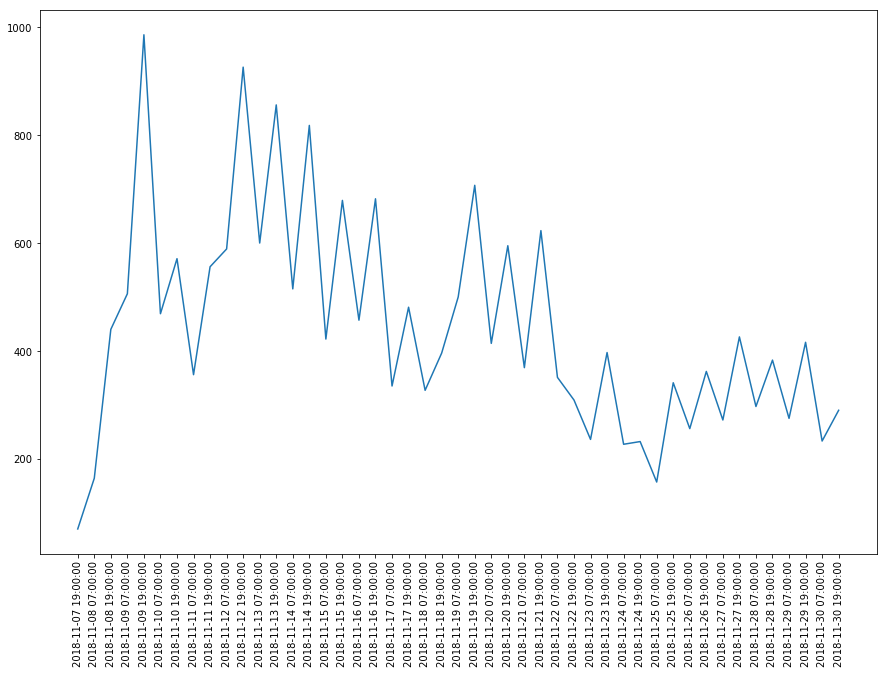

In [21]:
plt.figure(figsize = (15, 10))
plt.plot(df2.groupby(by = 'time_window')['time_window'].count())
plt.xticks(rotation='vertical')
plt.show()

In [22]:
df2.shape

(20869, 11)

In [ ]:
#instantiate a timer
news_table_name = 'news_camp_fire'
start_execution = time.time()
print(f'Writing {df2.shape[0]} rows to {news_table_name}')

#write the data to a new table, overwrite if exist
write_to_database(df2, engine = engine, table = news_table_name, exist_action='replace')

end_execution = time.time()
print(f'Elapsed time: {end_execution - start_execution}')